####  <b>Introduction：</b>


This dataset was retrieved from an official Kaggle competition hosted on https://www.kaggle.com/competitions/amp-parkinsons-disease-progression-prediction/data. This notebook will aim at testing using neural networks to model the progressive changes on the targeted metrics. Contextually, the data is a kind of time-to-event (TTE) data, which is the concern of most survival analysis methods. Although the measurement scales of the 4 dimensions (Intellectual function & mood & behavior; Activities of daily living; Motor examination; Motor complications) could be associated and converted into an interpretation on the severity (none, mild, moderate, severe) somehow, without any concrete expertise, I was keeping the numerical values as regression outcomes instead of categorizing it and changing it into a classification task.
<br>
<br>

For the first part of the explanatory analysis, it could be seen that the 4-th dimension ("updrs_4") had 42% of missing values. For the ease of implementation, only the other 3 dimensions were considered. Measurements were taken respectively on peptide level and on protein levels. However, the composition of proteins and peptides (amino acids) involved for every patient across each visit (time step) could be varying, and hence the feature representation would be one of the difficulties of this implementation.
<br>
<br>

For the feature inputs, they are comprised of:
<ol>
<li>
Intuitively, the protein-peptide feature matrix would be of high sparsity (227 x 968), where Convolution layers could play in for structurally learning the latent patterns.
</li>
<li>
Another dimensionality-reduced matrix would be borrowing from language or temporal modelling, that treating the set of peptides like a sequence length, then at most there were 49 peptides for one protein. This could be jsutified by the fact that each type of proteins had a fixed set of peptides. Therefore, the matrix could be arranged in a shape of (227 x 49), and Transformer Encoding layers could provide attention functionality to generate and propagate the feature embeddings.
</li>
<li>
The "NPX" feature per protein level could be attributed to an additional information of shape (227 x 1).
</li>
</ol>

<br>

The second issue would be the frequency of measurements. Plotting the distributions of "visit month" in the protein and peptide datasets, it could be concluded other than the first half year (6 months), measurements were mostlly taken on a yearly basis (i.e., 12-th, 24-th, etc.), with a small proportion of exceptions in other months. Temporal data at time steps of multiples of 12, plus the first half year (6 months), were retained. Furthermore, since the goal of the competition was to predict the future measurement scale values on the subsequent 6-th, 12-th and 24-th months, that means it would be forecasting up to 3 time steps. After shifting the target columns of "updrs_1", "updrs_2", "updrs_3" to generate t + 1 (6 months), t + 2 (12 months) and t + 3 (24 months) advancement, rows containing NA values of targets were discarded, eventually leaving 6 time steps per each patient.

In [ ]:
import json
import copy
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from collections import Counter

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
train_clinic = pd.read_csv("train_clinical_data.csv")
supp_clinic = pd.read_csv("supplemental_clinical_data.csv")
train_peptides = pd.read_csv("train_peptides.csv")
train_proteins = pd.read_csv("train_proteins.csv")

In [ ]:
print(train_clinic.shape)
print(supp_clinic.shape)
print(train_peptides.shape)
print(train_proteins.shape)

(2615, 8)
(2223, 8)
(981834, 6)
(232741, 5)


In [ ]:
####  a sample record of target outcomes derived from Unified Parkinson's Disease Rating Scale (MDS-UPDRS) for patients
##  paitient with partially-censored data for "updrs_4" and "upd23b_clinical_state_on_medication"
train_clinic[train_clinic['patient_id'] == 55]

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,55,0,10.0,6.0,6,NaN,NaN
1,55_3,55,3,10.0,7.0,19,NaN,NaN
2,55_6,55,6,8.0,10.0,58,NaN,NaN
3,55_9,55,9,8.0,9.0,17,0.0,On
4,55_12,55,12,10.0,10.0,2,0.0,On
5,55_18,55,18,7.0,13.0,7,0.0,On
6,55_24,55,24,16.0,9.0,16,0.0,On
7,55_30,55,30,14.0,13.0,21,0.0,On
8,55_36,55,36,17.0,18.0,9,0.0,On
9,55_42,55,42,12.0,20.0,4,0.0,On


In [ ]:
train_clinic['updrs_1'][pd.isnull(train_clinic['updrs_1'])] = 0
train_clinic['updrs_2'][pd.isnull(train_clinic['updrs_2'])] = 0
train_clinic['updrs_3'][pd.isnull(train_clinic['updrs_3'])] = 0

In [ ]:
### whether measurements have been taken per visit
train_clinic['measurements'] = train_clinic['visit_id'].apply(lambda x: "Y" if x in train_measures['visit_id'].values.tolist() else "N")

In [ ]:
### trim / remove last few visit(s) if a new measurement was taken, but no later follow-up
# get the arranged visit serial number
train_clinic['visit_serial_no'] = train_clinic.groupby(['patient_id']).cumcount()
train_clinic['visit_total'] = train_clinic.groupby('patient_id')['visit_serial_no'].transform(max)
# get the last visit with / without measurement taken
train_clinic['visit_max_no_measure'] = train_clinic.groupby(['patient_id','measurements'])['visit_serial_no'].transform(max)
# mask the last visit with measurement
train_clinic['visit_max_no_measure'] = train_clinic.apply(lambda x: np.nan if x['measurements'] == "Y" else x['visit_max_no_measure'], axis = 1)
train_clinic['visit_max_no_measure'][pd.isnull(train_clinic['visit_max_no_measure'])] = train_clinic.groupby('patient_id')['visit_max_no_measure'].transform(max)

In [ ]:
### trim / remove the visit id list for measurements taken during the most recent visit(s)
non_exclude_visit = train_clinic[~(
    (train_clinic['measurements'] == "Y") &
    (train_clinic['visit_serial_no'] > train_clinic['visit_max_no_measure'])
    )]['visit_id']

In [ ]:
#### make target arrays
##### update clinic dataframe to exclude discarded visits
train_clinic = train_clinic[train_clinic['visit_id'].isin(non_exclude_visit.values.tolist())]
##### update clinic dataframe to exclude visit months of high rarity
train_clinic = train_clinic[~train_clinic['visit_month'].isin([3,9,18,30,42,54,96,108])]

In [ ]:
train_clinic

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication,measurements,visit_serial_no,visit_total,visit_max_no_measure
0,55_0,55,0,10.0,6.0,6,NaN,NaN,Y,0,12,12.0
2,55_6,55,6,8.0,10.0,58,NaN,NaN,Y,2,12,12.0
3,55_9,55,9,8.0,9.0,17,0.0,On,N,3,12,12.0
4,55_12,55,12,10.0,10.0,2,0.0,On,Y,4,12,12.0
6,55_24,55,24,16.0,9.0,16,0.0,On,N,6,12,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2609,65043_42,65043,42,9.0,10.0,4,0.0,Off,N,9,14,14.0
2610,65043_48,65043,48,7.0,6.0,51,0.0,Off,Y,10,14,14.0
2612,65043_60,65043,60,6.0,6.0,0,1.0,Off,N,12,14,14.0
2613,65043_72,65043,72,3.0,9.0,58,1.0,Off,N,13,14,14.0


In [ ]:
####  check NA in the target outcomes derived from Unified Parkinson's Disease Rating Scale (MDS-UPDRS)
train_clinic[['updrs_1','updrs_2','updrs_3','updrs_4','upd23b_clinical_state_on_medication']].apply(lambda x: x.isna().sum())

updrs_1                                   1
updrs_2                                   2
updrs_3                                   0
updrs_4                                1016
upd23b_clinical_state_on_medication    1289
dtype: int64

In [ ]:
###  Missing rates of target variables
train_clinic[['updrs_1','updrs_2','updrs_3','updrs_4','upd23b_clinical_state_on_medication']].apply(lambda x: x.isna().sum() / train_clinic.shape[0] * 100)

updrs_1                                 0.000000
updrs_2                                 0.000000
updrs_3                                 0.000000
updrs_4                                42.442173
upd23b_clinical_state_on_medication    53.200646
dtype: float64

In [ ]:
####  Protein Measurement Variable:  NPX
train_proteins.head(10)

,visit_id,visit_month,patient_id,UniProt,NPX
0,55_0,0,55,O00391,11254.30
1,55_0,0,55,O00533,732430.00
2,55_0,0,55,O00584,39585.80
3,55_0,0,55,O14498,41526.90
4,55_0,0,55,O14773,31238.00
5,55_0,0,55,O14791,4202.71
6,55_0,0,55,O15240,177775.00
7,55_0,0,55,O15394,62898.20
8,55_0,0,55,O43505,333376.00
9,55_0,0,55,O60888,166850.00


In [ ]:
####  Peptide Measurement Variable:  Abundance
train_peptides.head(10)

,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance
0,55_0,0,55,O00391,NEQEQPLGQWHLS,11254.3
1,55_0,0,55,O00533,GNPEPTFSWTK,102060.0
2,55_0,0,55,O00533,IEIPSSVQQVPTIIK,174185.0
3,55_0,0,55,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.9
4,55_0,0,55,O00533,SMEQNGPGLEYR,30838.7
5,55_0,0,55,O00533,TLKIENVSYQDKGNYR,23216.5
6,55_0,0,55,O00533,VIAVNEVGR,170878.0
7,55_0,0,55,O00533,VMTPAVYAPYDVK,148771.0
8,55_0,0,55,O00533,VNGSPVDNHPFAGDVVFPR,55202.1
9,55_0,0,55,O00584,ELDLNSVLLK,27229.3


In [ ]:
### UniProt - The UniProt ID code for the associated protein.
###  There are often several peptides per protein.
###  The test set may include proteins not found in the train set.

##  check number of proteins in both datasets for consistency
print("UniProt in proteins : " + str(len(set(train_proteins['UniProt']))))
print("UniProt in peptides : " + str(len(set(train_peptides['UniProt']))))

UniProt in proteins : 227
UniProt in peptides : 227


In [ ]:
##  check number of peptides in the dataset for consistency
print("Unique Peptides : " + str(len(set(train_peptides['Peptide']))))

Unique Peptides : 968


In [ ]:
##  check number of patients in both datasets for consistency
print("Patients in proteins : " + str(len(set(train_proteins['patient_id']))))
print("Patients in peptides : " + str(len(set(train_peptides['patient_id']))))
##  check number of visits in both datasets for consistency
print("Patient Visits in proteins : " + str(len(set(train_proteins['visit_id']))))
print("Patient Visits in peptides : " + str(len(set(train_peptides['visit_id']))))

Patients in proteins : 248
Patients in peptides : 248
Patient Visits in proteins : 1113
Patient Visits in peptides : 1113


In [ ]:
### merging meausurements of Peptides per each Protein taken during each single visit
train_measures = train_peptides.merge(train_proteins, on=['UniProt','patient_id','visit_id','visit_month'], how="left")

In [ ]:
train_measures

,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance,NPX
0,55_0,0,55,O00391,NEQEQPLGQWHLS,11254.30,11254.3
1,55_0,0,55,O00533,GNPEPTFSWTK,102060.00,732430.0
2,55_0,0,55,O00533,IEIPSSVQQVPTIIK,174185.00,732430.0
3,55_0,0,55,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.90,732430.0
4,55_0,0,55,O00533,SMEQNGPGLEYR,30838.70,732430.0
...,...,...,...,...,...,...,...
981829,58648_108,108,58648,Q9UHG2,ILAGSADSEGVAAPR,202820.00,369437.0
981830,58648_108,108,58648,Q9UKV8,SGNIPAGTTVDTK,105830.00,105830.0
981831,58648_108,108,58648,Q9Y646,LALLVDTVGPR,21257.60,21257.6
981832,58648_108,108,58648,Q9Y6R7,AGC(UniMod_4)VAESTAVC(UniMod_4)R,5127.26,17953.1


<ipython-input-27-a738b016bf9c>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_measures['visit_month'])


<Axes: xlabel='visit_month', ylabel='Density'>

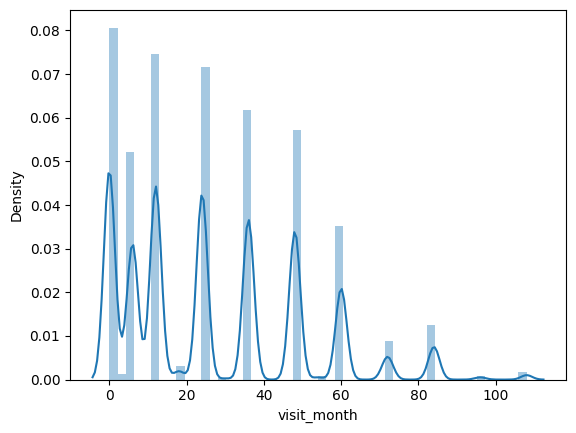

In [ ]:
###   when will these Protein and Peptide measurements (on which visits) be taken?
sns.distplot(train_measures['visit_month'])

<ipython-input-29-c7b1e96d9136>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_clinic['visit_month'])


<Axes: xlabel='visit_month', ylabel='Density'>

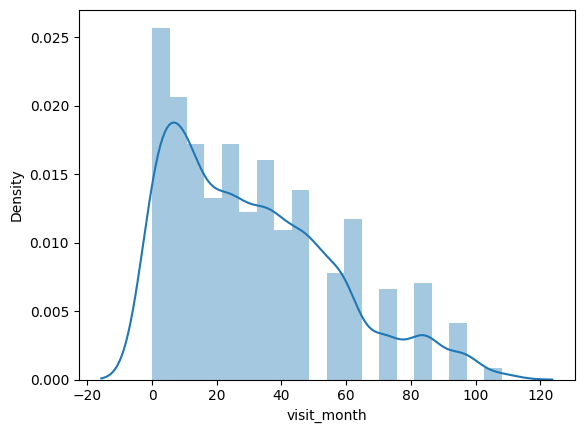

In [ ]:
###   when will these patient revisits occur?
sns.distplot(train_clinic['visit_month'])

In [ ]:
###   when will these Protein and Peptide measurements (on which visits) be taken?
Counter(train_measures['visit_month'])

Counter({0: 171048,
         3: 2742,
         6: 110733,
         12: 158114,
         18: 6822,
         24: 152036,
         30: 913,
         36: 130903,
         48: 121343,
         54: 1801,
         60: 74562,
         72: 18642,
         84: 26729,
         96: 1815,
         108: 3631})

In [ ]:
###   when will these patient revisits occur?
Counter(train_clinic['visit_month'])

Counter({0: 248,
         3: 115,
         6: 192,
         9: 99,
         12: 241,
         18: 187,
         24: 236,
         30: 173,
         36: 206,
         42: 154,
         48: 171,
         54: 109,
         60: 141,
         72: 86,
         84: 85,
         96: 56,
         108: 9})

In [ ]:
###  pivot targets (keeping 1, 2, 3 for data completeness)
targets = train_clinic[["visit_id","patient_id","visit_month","updrs_1","updrs_2","updrs_3"]]\
            .pivot_table(index=["visit_id","patient_id","visit_month"], values=['updrs_1','updrs_2','updrs_3'])\
            .sort_values(by=['patient_id','visit_month'])\
            .reset_index()

###  create targets forecastng up to 3 time steps
targets['updrs_1_after_1'] = targets.groupby(["patient_id"])['updrs_1'].shift(-1)
targets['updrs_1_after_2'] = targets.groupby(["patient_id"])['updrs_1'].shift(-2)
targets['updrs_1_after_3'] = targets.groupby(["patient_id"])['updrs_1'].shift(-3)
targets['updrs_2_after_1'] = targets.groupby(["patient_id"])['updrs_2'].shift(-1)
targets['updrs_2_after_2'] = targets.groupby(["patient_id"])['updrs_2'].shift(-2)
targets['updrs_2_after_3'] = targets.groupby(["patient_id"])['updrs_2'].shift(-3)
targets['updrs_3_after_1'] = targets.groupby(["patient_id"])['updrs_3'].shift(-1)
targets['updrs_3_after_2'] = targets.groupby(["patient_id"])['updrs_3'].shift(-2)
targets['updrs_3_after_3'] = targets.groupby(["patient_id"])['updrs_3'].shift(-3)

###  remove all time steps with NAs in targets
targets = targets.dropna()

In [ ]:
targets

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_1_after_1,updrs_1_after_2,updrs_1_after_3,updrs_2_after_1,updrs_2_after_2,updrs_2_after_3,updrs_3_after_1,updrs_3_after_2,updrs_3_after_3
0,55_0,55,0,10.0,6.0,6,8.0,10.0,16.0,10.0,10.0,9.0,58.0,2.0,16.0
1,55_6,55,6,8.0,10.0,58,10.0,16.0,17.0,10.0,9.0,18.0,2.0,16.0,9.0
2,55_12,55,12,10.0,10.0,2,16.0,17.0,17.0,9.0,18.0,16.0,16.0,9.0,51.0
3,55_24,55,24,16.0,9.0,16,17.0,17.0,23.0,18.0,16.0,21.0,9.0,51.0,0.0
7,942_0,942,0,3.0,2.0,6,8.0,5.0,2.0,2.0,2.0,3.0,58.0,2.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1598,65043_6,65043,6,3.0,6.0,58,4.0,4.0,2.0,7.0,8.0,7.0,2.0,16.0,9.0
1599,65043_12,65043,12,4.0,7.0,2,4.0,2.0,7.0,8.0,7.0,6.0,16.0,9.0,51.0
1600,65043_24,65043,24,4.0,8.0,16,2.0,7.0,6.0,7.0,6.0,6.0,9.0,51.0,0.0
1601,65043_36,65043,36,2.0,7.0,9,7.0,6.0,3.0,6.0,6.0,9.0,51.0,0.0,58.0


In [ ]:
##### update measurement dataframe to exclude discarded visits
train_measures = train_measures[train_measures['visit_id'].isin(non_exclude_visit.values.tolist())]
##### update measurement dataframe to exclude visit months of high rarity
train_measures = train_measures[~train_measures['visit_month'].isin([3,18,30,54,96,108])]

In [ ]:
#### 1) protein         specific feature matrix
#### 2) protein-peptide specific feature matrix

####  peptides as sequential position; different for each protein
train_measures['peptide_seq_no'] = train_measures.groupby(['patient_id','visit_id','UniProt'])['Peptide']\
                                                  .transform(lambda x: pd.factorize(x)[0])
train_measures['peptide_seq_no'] = train_measures['peptide_seq_no']\
                                                .apply(lambda x: 'peptide_' + str(x))
####  min-max scale peptide-specific values
train_measures['peptide_abundance'] = train_measures.groupby(['UniProt','Peptide'])['PeptideAbundance']\
                                                  .transform(lambda x: (x - np.nanmin(x)) / (np.nanmax(x) - np.nanmin(x)))
####  min-max protein-specific values
train_measures['npx'] = train_measures.groupby('UniProt')['NPX']\
                                                  .transform(lambda x: (x - np.nanmin(x)) / (np.nanmax(x) - np.nanmin(x)))

####  only include trainable time steps (with targets)
train_measures = train_measures[train_measures['visit_id'].isin(
    targets.apply(lambda x: str(int(x['patient_id'])) + '_' + str(int(x['visit_month'])), axis = 1).values.tolist()
    )]

In [ ]:
####  geenrate positional embedding for peptides per protein
pos_dict = [(i, v) for i, v in enumerate(sorted(list(set(train_measures['Peptide']))))]
pos_dict = pd.DataFrame(pos_dict)
pos_dict.columns = ["peptide_key","Peptide"]
train_measures = train_measures.merge(pos_dict, how="left", on="Peptide")

In [ ]:
from collections import Counter
print("Max Seq Length for Peptides : " + str(len(Counter(train_measures['peptide_seq_no']))))
print("Number (Corpus) for Peptides : " + str(len(Counter(train_measures['Peptide']))))

Max Seq Length for Peptides : 49
Number (Corpus) for Peptides : 968


In [ ]:
#### pivot proteins
train_sample_protein_matrix = train_measures[["patient_id","visit_month","UniProt","npx"]]\
                                .drop_duplicates()\
                                .sort_values(by=['patient_id','visit_month'])\
                                .pivot_table(index=["patient_id","visit_month","UniProt"],
                                             values="npx")

#### pivot peptide
train_sample_peptide_matrix = train_measures[["patient_id","visit_month","UniProt","Peptide","peptide_abundance"]]\
                                    .sort_values(by=['patient_id','visit_month'])\
                                    .pivot(index=["patient_id","visit_month","UniProt"],
                                           columns="Peptide",
                                           values="peptide_abundance")

train_sample_peptide_matrix = train_sample_peptide_matrix.fillna(0)

#### pivot peptide sequence
train_sample_peptide_seq_matrix = train_measures[["patient_id","visit_month","UniProt","peptide_seq_no","peptide_abundance"]]\
                                    .sort_values(by=['patient_id','visit_month'])\
                                    .pivot(index=["patient_id","visit_month","UniProt"],
                                           columns="peptide_seq_no",
                                           values="peptide_abundance")

train_sample_peptide_seq_matrix_2 = train_measures[["patient_id","visit_month","UniProt","peptide_seq_no","peptide_abundance"]]\
                                      .sort_values(by=['patient_id','visit_month'])\
                                      .pivot(index=["patient_id","visit_month","UniProt"],
                                            columns="peptide_seq_no",
                                            values="peptide_key")

train_sample_peptide_seq_matrix_2 = train_sample_peptide_seq_matrix_2.fillna(-1)

#### column re-arrangement for 1 - 10 due to non-numeric ordering
train_sample_peptide_seq_matrix = train_sample_peptide_seq_matrix[
     ['peptide_' + str(x) for x in range(10)] +
     [y for y in train_sample_peptide_seq_matrix.columns if y not in ['peptide_' + str(x) for x in range(10)]]
     ]

In [ ]:
###  distributional statistics for imputation
impute_medians = train_sample_peptide_seq_matrix.apply(lambda x: x.median(), axis = 0)
impute_uppers = train_sample_peptide_seq_matrix.apply(lambda x: x.quantile(0.75), axis = 0)
impute_lowers = train_sample_peptide_seq_matrix.apply(lambda x: x.quantile(0.25), axis = 0)
impute_dist = pd.DataFrame({"q2":impute_medians, "q3":impute_uppers, "q1":impute_lowers})

In [ ]:
###  missing value imputation for Peptide sequences
for n in train_sample_peptide_seq_matrix.columns:
    for id in list(train_sample_peptide_seq_matrix.index):
        if pd.isnull(train_sample_peptide_seq_matrix.loc[id, n]):
            mu = impute_dist.loc[n, "q2"]
            sigma = (impute_dist.loc[n, "q3"] - impute_dist.loc[n, "q1"]) / 2
            train_sample_peptide_seq_matrix.loc[id, n] = np.random.normal(mu, sigma, 1)[0]

In [ ]:
#### get 4-D array
train_sample_protein_matrix_array = train_sample_protein_matrix.to_xarray().to_array()
train_sample_protein_matrix_array = train_sample_protein_matrix_array.transpose('patient_id', 'visit_month', 'UniProt', 'variable')

train_sample_peptide_matrix_array = train_sample_peptide_matrix.to_xarray().to_array()
train_sample_peptide_matrix_array = train_sample_peptide_matrix_array.transpose('patient_id', 'visit_month', 'UniProt', 'variable')

train_sample_peptide_seq_matrix_array = train_sample_peptide_seq_matrix.to_xarray().to_array()
train_sample_peptide_seq_matrix_array = train_sample_peptide_seq_matrix_array.transpose('patient_id', 'visit_month', 'UniProt', 'variable')

train_sample_peptide_seq_matrix_array_2 = train_sample_peptide_seq_matrix_2.to_xarray().to_array()
train_sample_peptide_seq_matrix_array_2 = train_sample_peptide_seq_matrix_array_2.transpose('patient_id', 'visit_month', 'UniProt', 'variable')

In [ ]:
print(train_sample_protein_matrix_array.shape)
print(train_sample_peptide_matrix_array.values.shape)
print(train_sample_peptide_seq_matrix_array.values.shape)

(222, 6, 227, 1)
(222, 6, 227, 968)
(222, 6, 227, 49)


In [ ]:
#### get 3-D array
target_arrays = targets[
    targets['visit_id'].isin(
        train_measures.apply(lambda x: str(int(x['patient_id'])) + '_' + str(int(x['visit_month'])), axis = 1).values.tolist()
        )
    ]\
    .iloc[:, np.r_[1:3,6:targets.shape[1]]]\
    .set_index(["patient_id","visit_month"])

target_arrays = target_arrays.to_xarray().to_array()
target_arrays = target_arrays.transpose('patient_id', 'visit_month', 'variable')

In [ ]:
print(target_arrays.shape)

(222, 6, 9)


####  <b> Model Structure： </b>

Here are the feature inputs and components of methodology of the pipeline building process:
<ol>

<li>
Feature Arrays:
<ul>
<li> Protein Features (batch_size, 6, 227, 1) </li>
<li> Pivoted Peptide Features (batch_size, 6, 227, 968) </li>
<li> Sequential Peptide Features (Values) (batch_size, 6, 227, 49) </li>
<li> Sequential Peptide Features (Indices) (batch_size, 6, 227, 49) </li>
</ul>
</li>

<br>

<li>
Pre-processing:
<ul>
<li>
Since not every patient had the same revisit intervals (i.e., some may revisit on the 24-th month, while some may postpone, and some may had already been discharged before the 24-th month), it would lead to a common problem in survival analysis, Censoring. To align all inputted units (patients) to have the same shape of numerical arrays, imputation to these censored values would be necessitated as neural networks do not allow missing values. In this notebook, interval-censored values would be forward-filled (i.e., passing the previous available observations) per each patient. Left and Right censored values would be filled with medians. <br><br>
</li>
<li>
Particular arrays like the sequential peptide features, -1 or 0 would be used to represent missing values, resembling the handling methods of fitting temporal or language models. <br><br>
</li>
<li>
Standaradization of numerical inputs would be done with the min-max normalization technique.
</li>
</ul>
</li>

<br>

<li>
Training Processes:
<ul>
<li> Protein Features  ==>  Convolution 1D  </li>
<li> Pivoted Peptide Featuress  ==>  Autoencoder (Convolution 2D) </li>
<li> Sequential Peptide Features (Values)  ==>  LSTM + Convolution 2D </li>
<li> Sequential Peptide Features (Indices)  ==>  Transformer Encoder with Attention + Convolution 2D </li>
</ul>

Concatenation of the above 4 inputs, and adopting flattening, the latent vectors would be undergoing several feed-forward dense layers until outputting a target value. For model simplicity, even though there were 9 targets, we would fit it one-by-one.
</li>

</ol>

In [ ]:
###  Autoencoder for dimensionality reduction of the protein-peptide 2-D features
class autoencoder(nn.Module):
    def __init__(self, n_hidden_layers, dim_width, dim_height, dim_depth):
        super(autoencoder, self).__init__()

        self.n_hidden_layers = n_hidden_layers
        self.dim_width = dim_width
        self.dim_height = dim_height
        self.dim_depth = dim_depth

        self.conv_1 = nn.Conv2d(self.dim_depth, self.dim_depth, kernel_size = (2,2), stride = (2,2), padding = (1,0))
        self.conv_2 = nn.Conv2d(self.dim_depth, self.dim_depth, kernel_size = (2,2), stride = (2,2), padding = 0)
        self.conv_3 = nn.Conv2d(self.dim_depth, self.dim_depth, kernel_size = (2,2), stride = (2,2), padding = (1,0))
        self.conv_tsp_1 = nn.ConvTranspose2d(self.dim_depth, self.dim_depth, kernel_size = (2,2), stride = (2,2), padding = (0,0))
        self.conv_tsp_2 = nn.ConvTranspose2d(self.dim_depth, self.dim_depth, kernel_size = (2,2), stride = (2,2), padding = (1,0))
        self.conv_tsp_3 = nn.ConvTranspose2d(self.dim_depth, self.dim_depth, kernel_size = (2,2), stride = (2,2), padding = (0,0))
        self.conv_hide = nn.Conv2d(self.dim_depth, self.dim_depth, kernel_size = (1,1), stride = (1,1), padding = 0)
        self.conv_extract = nn.Conv2d(self.dim_depth, self.dim_depth, kernel_size = (1,1), stride = (1,1), padding = 0)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.conv_1(x)
        x = self.dropout(x)
        x = self.conv_2(x)
        x = self.dropout(x)
        x = self.conv_3(x)
        x = self.dropout(x)
        for n in range(self.n_hidden_layers):
            x = self.conv_hide(x)
        x = self.conv_extract(x)
        x = self.conv_tsp_1(x)
        x = self.conv_tsp_2(x)
        x = self.conv_tsp_3(x)
        return x

In [ ]:
ate = autoencoder(n_hidden_layers = 3,
                  dim_width = 968,
                  dim_height = 227,
                  dim_depth = 6)

In [ ]:
from torchsummary import summary
summary(ate, input_size = (6,227,968), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 114, 484]             150
           Dropout-2          [-1, 6, 114, 484]               0
            Conv2d-3           [-1, 6, 57, 242]             150
           Dropout-4           [-1, 6, 57, 242]               0
            Conv2d-5           [-1, 6, 29, 121]             150
           Dropout-6           [-1, 6, 29, 121]               0
            Conv2d-7           [-1, 6, 29, 121]              42
            Conv2d-8           [-1, 6, 29, 121]              42
            Conv2d-9           [-1, 6, 29, 121]              42
           Conv2d-10           [-1, 6, 29, 121]              42
  ConvTranspose2d-11           [-1, 6, 58, 242]             150
  ConvTranspose2d-12          [-1, 6, 114, 484]             150
  ConvTranspose2d-13          [-1, 6, 228, 968]             150
Total params: 1,068
Trainable params: 1

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_sample_peptide_matrix_array = torch.utils.data.TensorDataset(torch.tensor(train_sample_peptide_matrix_array).to(torch.float32).to(device),
                                                                   torch.tensor(train_sample_peptide_matrix_array).to(torch.float32).to(device))
ate = ate.to(device)

In [ ]:
epochs = 50
optimizer = torch.optim.Adam(ate.parameters(), lr = 0.00005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, min_lr=5e-6)
traindataloader = DataLoader(train_sample_peptide_matrix_array, batch_size = 2, shuffle=True)

train_loss = list()

for epoch in range(epochs):
    ate.train()
    for i, (batch_x, batch_y) in enumerate(traindataloader):
        ## iteration training
        optimizer.zero_grad()
        out = ate(batch_x)
        out = out[:,:,1:,:]
        loss = nn.PoissonNLLLoss()(out, batch_y)
        loss.backward()
        optimizer.step()

    print("Epoch " + str(epoch+1) + " || " + \
          "train_loss: {:.4f}".format(loss.item()))

    train_loss.append(loss.item())

Epoch 1 || train_loss: 1.0500
Epoch 2 || train_loss: 1.0394
Epoch 3 || train_loss: 1.0274
Epoch 4 || train_loss: 1.0130
Epoch 5 || train_loss: 0.9950
Epoch 6 || train_loss: 0.9694
Epoch 7 || train_loss: 0.9259
Epoch 8 || train_loss: 0.8384
Epoch 9 || train_loss: 0.6745
Epoch 10 || train_loss: 0.4563
Epoch 11 || train_loss: 0.2747
Epoch 12 || train_loss: 0.1643
Epoch 13 || train_loss: 0.1048
Epoch 14 || train_loss: 0.0744
Epoch 15 || train_loss: 0.0567
Epoch 16 || train_loss: 0.0440
Epoch 17 || train_loss: 0.0378
Epoch 18 || train_loss: 0.0328
Epoch 19 || train_loss: 0.0283
Epoch 20 || train_loss: 0.0241
Epoch 21 || train_loss: 0.0246
Epoch 22 || train_loss: 0.0196
Epoch 23 || train_loss: 0.0199
Epoch 24 || train_loss: 0.0181
Epoch 25 || train_loss: 0.0148
Epoch 26 || train_loss: 0.0212
Epoch 27 || train_loss: 0.0177
Epoch 28 || train_loss: 0.0155
Epoch 29 || train_loss: 0.0148
Epoch 30 || train_loss: 0.0157
Epoch 31 || train_loss: 0.0141
Epoch 32 || train_loss: 0.0227
Epoch 33 || train

In [ ]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [ ]:
ate.conv_extract.register_forward_hook(get_activation('conv_extract'))
latent_features = ate(torch.tensor(train_sample_peptide_matrix_array).to(torch.float32))

In [ ]:
activation['conv_extract'].numpy().shape

(222, 6, 29, 121)

In [ ]:
####   Functions for missing value handling

def get_forward_fill(arr, axis):
    idx_shape = tuple([slice(None)] + [np.newaxis] * (len(arr.shape) - axis - 1))
    idx = np.where(~np.isnan(arr), np.arange(arr.shape[axis])[idx_shape], 0)
    np.maximum.accumulate(idx, axis=axis, out=idx)
    slc = [np.arange(k)[tuple([slice(None) if dim==i else np.newaxis
        for dim in range(len(arr.shape))])]
        for i, k in enumerate(arr.shape)]
    slc[axis] = idx
    return arr[tuple(slc)]

def get_sample_median_fill(arr):
    nanmedian = np.nanmedian(arr, axis=(1,3))
    for n in range(arr.shape[0]):
        idx_nan = np.argwhere(np.isnan(arr[n]))
        for idx in idx_nan:
            i, j, k = idx
            arr[n,i,j,k] = nanmedian[n,j]
    return arr

In [ ]:
### read protein matrix
protein_features = copy.deepcopy(train_sample_protein_matrix_array)
### fill NA with forward fill methods and default medians
protein_features = get_forward_fill(protein_features, 1)
protein_features = get_sample_median_fill(protein_features)
protein_features[np.isnan(protein_features)] = np.nanmedian(protein_features)

In [ ]:
### read peptide seq matrix
peptide_seq_features = copy.deepcopy(train_sample_peptide_seq_matrix_array)
### fill NA with forward fill methods and default medians
peptide_seq_features = get_forward_fill(peptide_seq_features, 1)
peptide_seq_features = get_sample_median_fill(peptide_seq_features)
peptide_seq_features[np.isnan(peptide_seq_features)] = np.nanmedian(peptide_seq_features)

In [ ]:
### read peptide seq matrix
peptide_seq_features_2 = copy.deepcopy(train_sample_peptide_seq_matrix_array_2)
### fill -1 for NA
peptide_seq_features_2[np.isnan(peptide_seq_features_2)] = -1

In [ ]:
### read peptide autoencoded matrix
peptide_sparse_features = copy.deepcopy(activation['conv_extract'].numpy())
###  min max transformation
numerator = peptide_sparse_features - np.nanmin(peptide_sparse_features, axis=(1,2,3))[:, np.newaxis, np.newaxis, np.newaxis]
denominator = np.nanmax(peptide_sparse_features, axis=(1,2,3)) - np.nanmin(peptide_sparse_features, axis=(1,2,3))
peptide_sparse_features = numerator / denominator[:, np.newaxis, np.newaxis, np.newaxis]

In [ ]:
### read targets
targets = copy.deepcopy(target_array)
### fill NA with forward fill methods and default medians
targets = get_forward_fill(targets, 1)
targets[np.isnan(targets)] = np.nanmedian(targets)

In [ ]:
###  Model Class
class T2E_model(nn.Module):
    def __init__(self, dim_depth, dim_seq_length):
        super(T2E_model, self).__init__()

        self.dim_depth = dim_depth
        self.dim_seq_length = dim_seq_length

        self.conv_1a = nn.Conv2d(self.dim_depth, self.dim_depth, kernel_size = (3,11), stride = (1,11), padding = (1,0))
        self.conv_1b = nn.Conv2d(self.dim_depth, self.dim_depth, kernel_size = (3,11), stride = (1,11), padding = (1,0))
        self.conv_1c = nn.Conv2d(self.dim_depth, self.dim_depth, kernel_size = (3,11), stride = (1,11), padding = (1,0))
        self.conv_1d = nn.Conv2d(self.dim_depth, self.dim_depth, kernel_size = (3,11), stride = (1,11), padding = (1,0))
        self.conv_1 = nn.Conv2d(self.dim_depth, self.dim_depth, kernel_size = (1,1), stride = (1,2), padding = 0)

        self.conv_2a = nn.Conv2d(self.dim_depth, self.dim_depth, kernel_size = (2,1), stride = (2,1), padding = (1,0))
        self.conv_2b = nn.Conv2d(self.dim_depth, self.dim_depth, kernel_size = (2,1), stride = (2,1), padding = 0)
        self.conv_2c = nn.Conv2d(self.dim_depth, self.dim_depth, kernel_size = (2,1), stride = (2,1), padding = (1,0))

        self.lstm_3 = nn.LSTM(self.dim_seq_length, 64, num_layers=2, bidirectional=True)
        self.conv_3a = nn.Conv2d(self.dim_depth, self.dim_depth, kernel_size = (2,2), stride = (2,2), padding = (1,0))
        self.conv_3b = nn.Conv2d(self.dim_depth, self.dim_depth, kernel_size = (2,2), stride = (2,2), padding = 0)
        self.conv_3c = nn.Conv2d(self.dim_depth, self.dim_depth, kernel_size = (2,2), stride = (2,2), padding = (1,0))

        self.transformer_encoder_layer_4 = nn.TransformerEncoderLayer(d_model=self.dim_seq_length, nhead=self.dim_depth+1, dim_feedforward=64)
        self.transformer_encoder_4 = nn.TransformerEncoder(self.transformer_encoder_layer_4, num_layers=3)
        self.transformer_mlp_head_4 = nn.Sequential(
                                            nn.LayerNorm(self.dim_seq_length),
                                            nn.Linear(self.dim_seq_length, 128)
                                      )
        self.conv_4a = nn.Conv2d(self.dim_depth, self.dim_depth, kernel_size = (2,2), stride = (2,2), padding = (1,0))
        self.conv_4b = nn.Conv2d(self.dim_depth, self.dim_depth, kernel_size = (2,2), stride = (2,2), padding = 0)
        self.conv_4c = nn.Conv2d(self.dim_depth, self.dim_depth, kernel_size = (2,2), stride = (2,2), padding = (1,0))

        self.dense_5a = nn.Linear(29*(22+16+16+1), 1152)
        self.dense_5b = nn.Linear(1152, 256)
        self.dense_5c = nn.Linear(256, 64)
        self.dense_5d = nn.Linear(64, 1)

        self.bnorm_1 = nn.BatchNorm2d(self.dim_depth)
        self.bnorm_2 = nn.BatchNorm2d(self.dim_depth)
        self.bnorm_3a = nn.BatchNorm2d(self.dim_depth)
        self.bnorm_3b = nn.BatchNorm2d(self.dim_depth)
        self.bnorm_3c = nn.BatchNorm2d(self.dim_depth)
        self.bnorm_4a = nn.BatchNorm2d(self.dim_depth)
        self.bnorm_4b = nn.BatchNorm2d(self.dim_depth)
        self.bnorm_4c = nn.BatchNorm2d(self.dim_depth)

        self.activation = nn.ReLU()
        self.flatten = torch.nn.Flatten(start_dim=2, end_dim=-1)
        self.dropout = nn.Dropout(p=0.25)

    def encoder_protein(self, x):
        x = self.conv_2a(x)
        x = self.bnorm_2(self.activation(x))
        x = self.conv_2b(x)
        x = self.bnorm_2(self.activation(x))
        x = self.conv_2c(x)
        x = self.bnorm_2(self.activation(x))
        return x

    def encoder_peptide(self, x):
        x1 = self.conv_1a(x)
        x2 = self.conv_1b(x)
        x3 = self.conv_1c(x)
        x4 = self.conv_1d(x)
        x_out = torch.stack((x1,x2,x3,x4), dim=4)
        x_out = torch.nn.Flatten(start_dim=3, end_dim=4)(x_out)
        x = self.conv_1(x_out)
        x = self.bnorm_1(self.activation(x))
        return x

    def encoder_peptide_seq_values(self, x):
        B, T, S, F = x.shape
        x = torch.nn.Flatten(start_dim=0, end_dim=1)(x)
        x = self.lstm_3(x)[0]
        x = torch.nn.Unflatten(0, (B,T))(x)
        x = self.conv_3a(x)
        x = self.bnorm_3a(self.activation(x))
        x = self.conv_3b(x)
        x = self.bnorm_3b(self.activation(x))
        x = self.conv_3c(x)
        x = self.bnorm_3c(self.activation(x))
        return x

    def encoder_peptide_seq_indices(self, x):
        B, T, S, F = x.shape
        x = torch.nn.Flatten(start_dim=0, end_dim=1)(x)
        x = self.transformer_encoder_4(x)
        x = self.transformer_mlp_head_4(x)
        x = torch.nn.Unflatten(0, (B,T))(x)
        x = self.conv_4a(x)
        x = self.bnorm_4a(self.activation(x))
        x = self.conv_4b(x)
        x = self.bnorm_4b(self.activation(x))
        x = self.conv_4c(x)
        x = self.bnorm_4c(self.activation(x))
        return x

    def forward(self, pt, pep, peps1, peps2):
        pt = self.encoder_protein(pt)
        pep = self.encoder_peptide(pep)
        peps1 = self.encoder_peptide_seq_values(peps1)
        peps2 = self.encoder_peptide_seq_indices(peps2)

        pt = self.flatten(pt)
        pep = self.flatten(pep)
        peps1 = self.flatten(peps1)
        peps2 = self.flatten(peps2)

        x = torch.cat((pt, pep, peps1, peps2), dim = 2)

        x = self.dense_5a(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.dense_5b(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.dense_5c(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.dense_5d(x)
        x = self.activation(x)
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = T2E_model(dim_depth = 6, dim_seq_length = 49)
model = model.to(device)

In [ ]:
from torchinfo import summary
summary(model, input_size = [(1,6,227,1),
                             (1,6,29,121),
                             (1,6,227,49),
                             (1,6,227,49)],device="cuda")

Layer (type:depth-idx)                        Output Shape              Param #
T2E_model                                     [1, 6, 1]                 16,381
├─Conv2d: 1-1                                 [1, 6, 114, 1]            78
├─ReLU: 1-2                                   [1, 6, 114, 1]            --
├─BatchNorm2d: 1-3                            [1, 6, 114, 1]            12
├─Conv2d: 1-4                                 [1, 6, 57, 1]             78
├─ReLU: 1-5                                   [1, 6, 57, 1]             --
├─BatchNorm2d: 1-6                            [1, 6, 57, 1]             (recursive)
├─Conv2d: 1-7                                 [1, 6, 29, 1]             78
├─ReLU: 1-8                                   [1, 6, 29, 1]             --
├─BatchNorm2d: 1-9                            [1, 6, 29, 1]             (recursive)
├─Conv2d: 1-10                                [1, 6, 29, 11]            1,194
├─Conv2d: 1-11                                [1, 6, 29, 11]          

In [ ]:
import random

###  train-test splits
test_idx = random.sample([x for x in range(222)], 22)
train_idx = [x for x in range(222) if x not in test_idx]

tr_protein_features = protein_features[train_idx, :, :, :]
tr_peptide_seq_features = peptide_seq_features[train_idx, :, :, :]
tr_peptide_seq_features_2 = peptide_seq_features_2[train_idx, :, :, :]
tr_peptide_sparse_features = peptide_sparse_features[train_idx, :, :, :]
tr_targets = targets[train_idx, :, 8]

ts_protein_features = protein_features[test_idx, :, :, :]
ts_peptide_seq_features = peptide_seq_features[test_idx, :, :, :]
ts_peptide_seq_features_2 = peptide_seq_features_2[test_idx, :, :, :]
ts_peptide_sparse_features = peptide_sparse_features[test_idx, :, :, :]
ts_targets = targets[test_idx, :, 8]

In [ ]:
print(tr_protein_features.shape)
print(tr_peptide_sparse_features.shape)
print(tr_peptide_seq_features.shape)
print(tr_peptide_seq_features_2.shape)
print(tr_targets.shape)

(200, 6, 227, 1)
(200, 6, 29, 121)
(200, 6, 227, 49)
(200, 6, 227, 49)
(200, 6)


In [ ]:
epochs = 300
optimizer = torch.optim.Adam(model.parameters(), lr = 5e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=5e-7)
traindataloader = DataLoader(
    torch.utils.data.TensorDataset(torch.tensor(tr_protein_features).to(torch.float32).cuda(),
                                   torch.tensor(tr_peptide_sparse_features).to(torch.float32).cuda(),
                                   torch.tensor(tr_peptide_seq_features).to(torch.float32).cuda(),
                                   torch.tensor(tr_peptide_seq_features_2).to(torch.float32).cuda(),
                                   torch.tensor(tr_targets).to(torch.float32).cuda()),
    batch_size = 4, shuffle=True)

train_loss = list()

for epoch in range(epochs):
    model.train()
    for i, (batch_pt, batch_pep, batch_peps1, batch_peps2, batch_y) in enumerate(traindataloader):
        ## iteration training
        optimizer.zero_grad()
        out = model(batch_pt, batch_pep, batch_peps1, batch_peps2)
        loss = nn.L1Loss()(out, batch_y.view(-1, 6, 1))
        loss.backward()
        optimizer.step()

    print("Epoch " + str(epoch+1) + " || " + \
          "train_loss: {:.4f}".format(loss.item()))

    train_loss.append(loss.item())

####  <b>  Results Interpretation: </b>


The models appeared to be able to overfit the training samples. Due to a small number of patients (200 in the split training set), overfitting would be easily expected. The training results sounded pleasant given the mean absolute percentage error (MAPE) lying between 8% to 13%, and the concordance index (C-index) scores were mostly above 0.95, that showed the model's ability adapting to the predictive questions. Due to the difference in the scales of scoring ranges of "UPDRS 3", it numerically had a larger mean absolute error (MAE) and mean squared error (MSE), but the other two metrics (MAPE and C-index) were comparable to the other two UPDRS scales.

<br>

Training for 1,000 epochs might be over-killing, and 300 epochs were already sufficient in deriving a promising result. The testing set results were significantly worse due to intentional overfitting, but interestly, the testing MAPE and C-index scores for the 3 forecasted time steps of "UPDRS 3" manifested a remarkably better performance than "UPDRS 1" and "UPDRS 2". Especially for concordance index, they could reach 0.78 and even surpassing 0.9 for the 12-month and 24-month forecasts.

<br>

This phenomenon might still be associated with the scoring range differences among the three, but it could also be concluded that the machine learning models were likely to capture the generaly patterns of "UPDRS 3" better than the other two. Whether this would be related to the intrinsic design of the measurement sclaes or any medical factor (e.g., for "UPDRS 3" assessing mostly the body functions including speech, mobility, posture and gait, etc., these might be more consistent over time and gradually deteriorating without abrupt changes) , it would leave for the medical experts to advise.

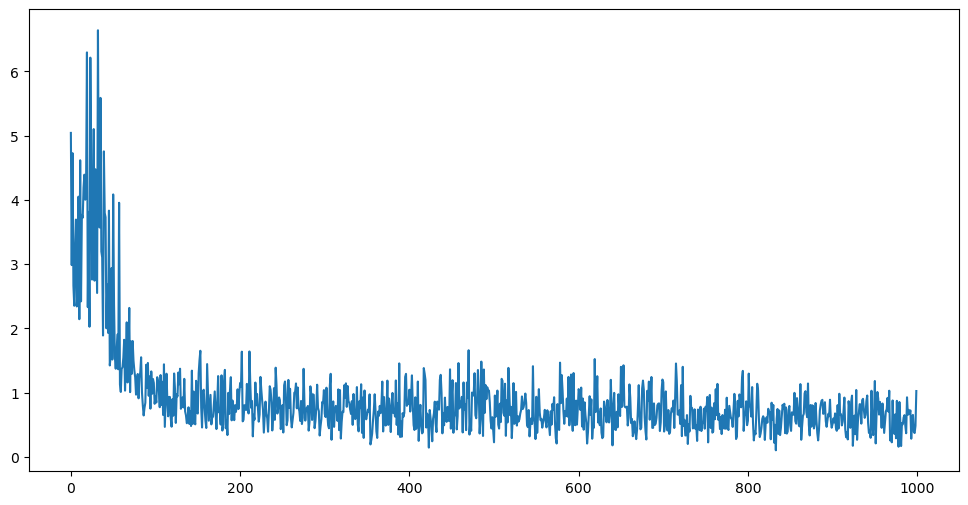

In [ ]:
####   Target 1)：   updrs_1 - after "1 time step"  (6 months)
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(train_loss)

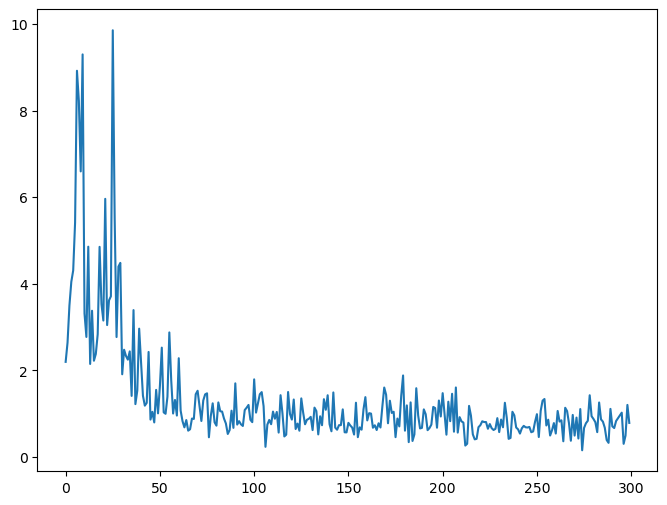

In [ ]:
####   Target 2)：   updrs_1 - after "2 time step"  (12 months)
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (8,6)
plt.plot(train_loss)

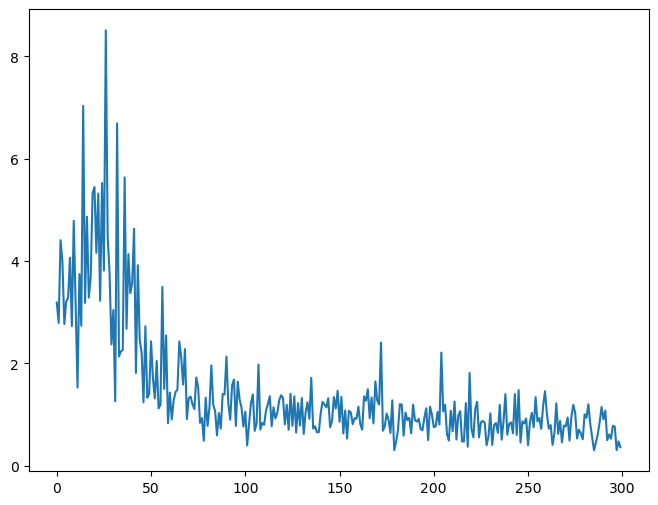

In [ ]:
####   Target 3)：   updrs_1 - after "3 time step"  (24 months)
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (8,6)
plt.plot(train_loss)

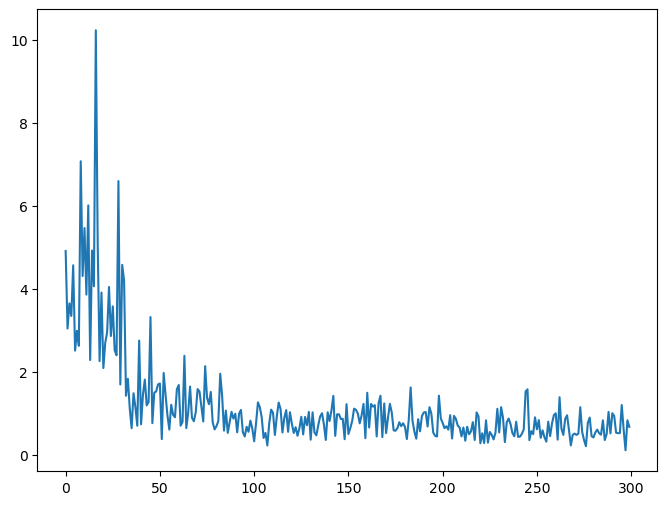

In [ ]:
####   Target 4)：   updrs_2 - after "1 time step"  (6 months)
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (8,6)
plt.plot(train_loss)

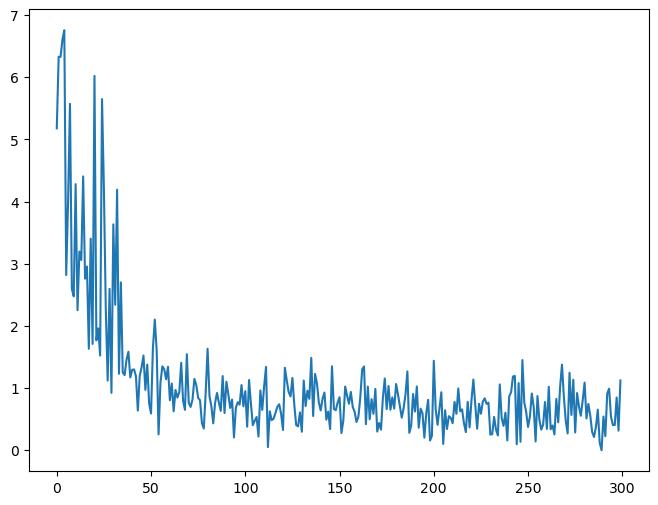

In [ ]:
####   Target 5)：   updrs_2 - after "2 time step"  (12 months)
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (8,6)
plt.plot(train_loss)

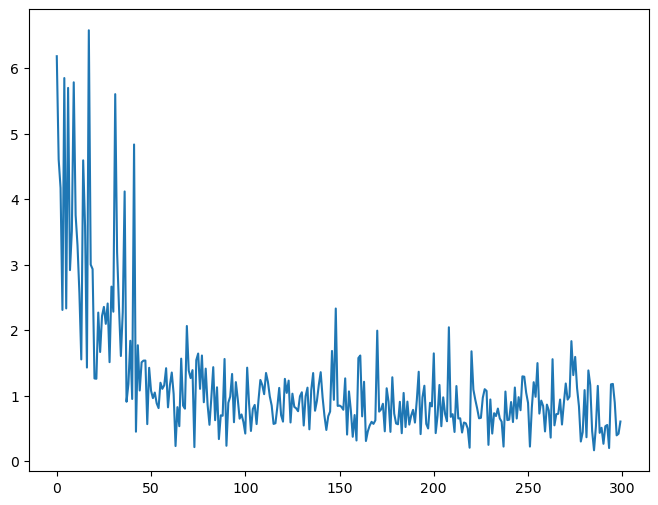

In [ ]:
####   Target 6)：   updrs_2 - after "3 time step"  (24 months)
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (8,6)
plt.plot(train_loss)

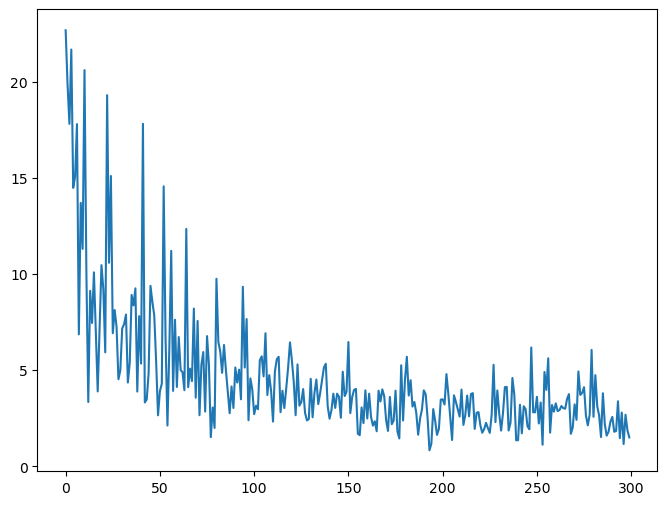

In [ ]:
####   Target 7)：   updrs_3 - after "1 time step"  (6 months)
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (8,6)
plt.plot(train_loss)

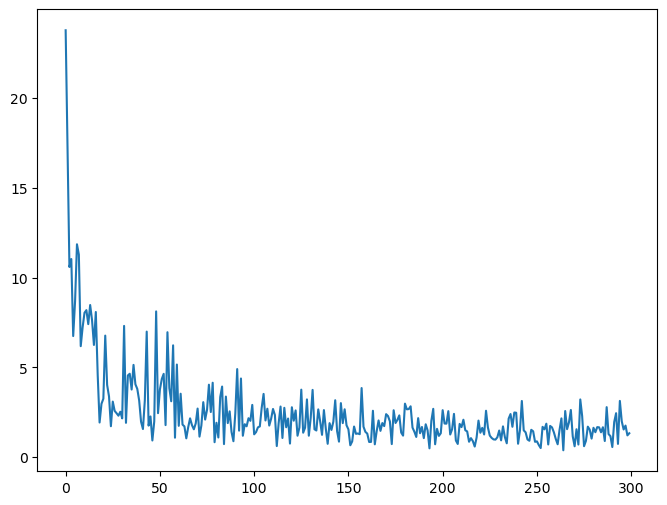

In [ ]:
####   Target 8)：   updrs_3 - after "2 time step"  (12 months)
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (8,6)
plt.plot(train_loss)

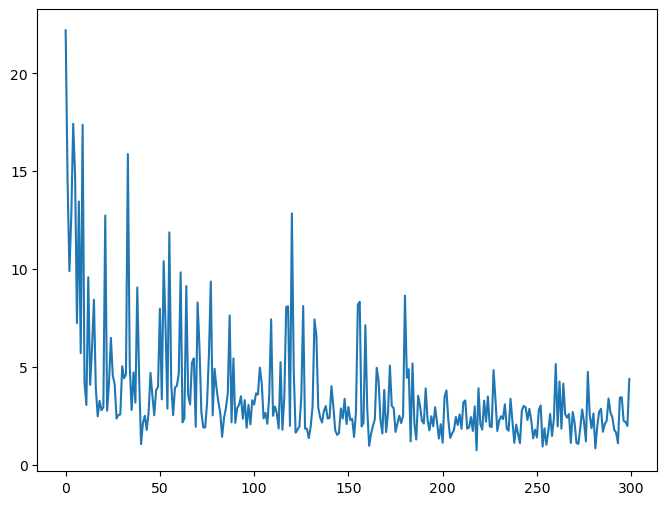

In [ ]:
####   Target 9)：   updrs_3 - after "3 time step"  (24 months)
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (8,6)
plt.plot(train_loss)

In [ ]:
from torchmetrics.functional.regression import mean_squared_error, concordance_corrcoef, mean_absolute_percentage_error, mean_absolute_error

In [ ]:
train_metrics = list()

for i, (batch_pt, batch_pep, batch_peps1, batch_peps2, batch_y) in enumerate(traindataloader):
    out = model(batch_pt, batch_pep, batch_peps1, batch_peps2)
    batch_y = batch_y.view(-1, 6, 1)
    mse = mean_squared_error(out, batch_y)
    mae = mean_absolute_error(out, batch_y)
    mape = mean_absolute_percentage_error(out, batch_y)
    batch_y = torch.nan_to_num(batch_y)
    cindex = concordance_corrcoef(out.flatten(), batch_y.flatten())

    train_metrics.append([mse.item(), mae.item(), mape.item(), cindex.item()])

In [ ]:
####   Target 1)：   updrs_1 - after "1 time step"  (6 months)
print("Training Set Median MSE : " + str(round(np.median([x[0] for x in train_metrics]), 4)))
print("Training Set Median MAE : " + str(round(np.median([x[1] for x in train_metrics]), 4)))
print("Training Set Median MAPE : " + str(round(np.median([x[2] for x in train_metrics]) * 100, 4)) + " %")
print("Training Set Median Concordance Index : " + str(round(np.median([x[3] for x in train_metrics]), 4)))

Training Set Median MSE : 0.7158
Training Set Median MAE : 0.5448
Training Set Median MAPE : 8.339 %
Training Set Median Concordance Index : 0.9772


In [ ]:
####   Target 2)：   updrs_1 - after "2 time step"  (12 months)
print("Training Set Median MSE : " + str(round(np.median([x[0] for x in train_metrics]), 4)))
print("Training Set Median MAE : " + str(round(np.median([x[1] for x in train_metrics]), 4)))
print("Training Set Median MAPE : " + str(round(np.median([x[2] for x in train_metrics]) * 100, 4)) + " %")
print("Training Set Median Concordance Index : " + str(round(np.median([x[3] for x in train_metrics]), 4)))

Training Set Median MSE : 1.1415
Training Set Median MAE : 0.7571
Training Set Median MAPE : 10.7956 %
Training Set Median Concordance Index : 0.9713


In [ ]:
####   Target 3)：   updrs_1 - after "3 time step"  (24 months)
print("Training Set Median MSE : " + str(round(np.median([x[0] for x in train_metrics]), 4)))
print("Training Set Median MAE : " + str(round(np.median([x[1] for x in train_metrics]), 4)))
print("Training Set Median MAPE : " + str(round(np.median([x[2] for x in train_metrics]) * 100, 4)) + " %")
print("Training Set Median Concordance Index : " + str(round(np.median([x[3] for x in train_metrics]), 4)))

Training Set Median MSE : 1.3875
Training Set Median MAE : 0.8446
Training Set Median MAPE : 11.665 %
Training Set Median Concordance Index : 0.9644


In [ ]:
####   Target 4)：   updrs_2 - after "1 time step"  (6 months)
print("Training Set Median MSE : " + str(round(np.median([x[0] for x in train_metrics]), 4)))
print("Training Set Median MAE : " + str(round(np.median([x[1] for x in train_metrics]), 4)))
print("Training Set Median MAPE : " + str(round(np.median([x[2] for x in train_metrics]) * 100, 4)) + " %")
print("Training Set Median Concordance Index : " + str(round(np.median([x[3] for x in train_metrics]), 4)))

Training Set Median MSE : 0.7619
Training Set Median MAE : 0.5684
Training Set Median MAPE : 9.1834 %
Training Set Median Concordance Index : 0.9806


In [ ]:
####   Target 5)：   updrs_2 - after "2 time step"  (12 months)
print("Training Set Median MSE : " + str(round(np.median([x[0] for x in train_metrics]), 4)))
print("Training Set Median MAE : " + str(round(np.median([x[1] for x in train_metrics]), 4)))
print("Training Set Median MAPE : " + str(round(np.median([x[2] for x in train_metrics]) * 100, 4)) + " %")
print("Training Set Median Concordance Index : " + str(round(np.median([x[3] for x in train_metrics]), 4)))

Training Set Median MSE : 0.8201
Training Set Median MAE : 0.5653
Training Set Median MAPE : 9.0208 %
Training Set Median Concordance Index : 0.9796


In [ ]:
####   Target 6)：   updrs_2 - after "3 time step"  (24 months)
print("Training Set Median MSE : " + str(round(np.median([x[0] for x in train_metrics]), 4)))
print("Training Set Median MAE : " + str(round(np.median([x[1] for x in train_metrics]), 4)))
print("Training Set Median MAPE : " + str(round(np.median([x[2] for x in train_metrics]) * 100, 4)) + " %")
print("Training Set Median Concordance Index : " + str(round(np.median([x[3] for x in train_metrics]), 4)))

Training Set Median MSE : 1.1847
Training Set Median MAE : 0.6724
Training Set Median MAPE : 9.7746 %
Training Set Median Concordance Index : 0.977


In [ ]:
####   Target 7)：   updrs_3 - after "1 time step"  (6 months)
print("Training Set Median MSE : " + str(round(np.median([x[0] for x in train_metrics]), 4)))
print("Training Set Median MAE : " + str(round(np.median([x[1] for x in train_metrics]), 4)))
print("Training Set Median MAPE : " + str(round(np.median([x[2] for x in train_metrics]) * 100, 4)) + " %")
print("Training Set Median Concordance Index : " + str(round(np.median([x[3] for x in train_metrics]), 4)))

Training Set Median MSE : 20.5393
Training Set Median MAE : 2.8303
Training Set Median MAPE : 13.2603 %
Training Set Median Concordance Index : 0.9788


In [ ]:
####   Target 8)：   updrs_3 - after "2 time step"  (12 months)
print("Training Set Median MSE : " + str(round(np.median([x[0] for x in train_metrics]), 4)))
print("Training Set Median MAE : " + str(round(np.median([x[1] for x in train_metrics]), 4)))
print("Training Set Median MAPE : " + str(round(np.median([x[2] for x in train_metrics]) * 100, 4)) + " %")
print("Training Set Median Concordance Index : " + str(round(np.median([x[3] for x in train_metrics]), 4)))

Training Set Median MSE : 5.233
Training Set Median MAE : 1.407
Training Set Median MAPE : 10.2317 %
Training Set Median Concordance Index : 0.9883


In [ ]:
####   Target 9)：   updrs_3 - after "3 time step"  (24 months)
print("Training Set Median MSE : " + str(round(np.median([x[0] for x in train_metrics]), 4)))
print("Training Set Median MAE : " + str(round(np.median([x[1] for x in train_metrics]), 4)))
print("Training Set Median MAPE : " + str(round(np.median([x[2] for x in train_metrics]) * 100, 4)) + " %")
print("Training Set Median Concordance Index : " + str(round(np.median([x[3] for x in train_metrics]), 4)))

Training Set Median MSE : 12.773
Training Set Median MAE : 2.1198
Training Set Median MAPE : 8.8359 %
Training Set Median Concordance Index : 0.9828


In [ ]:
testdataloader = DataLoader(
    torch.utils.data.TensorDataset(torch.tensor(ts_protein_features).to(torch.float32).cuda(),
                                   torch.tensor(ts_peptide_sparse_features).to(torch.float32).cuda(),
                                   torch.tensor(ts_peptide_seq_features).to(torch.float32).cuda(),
                                   torch.tensor(ts_peptide_seq_features_2).to(torch.float32).cuda(),
                                   torch.tensor(ts_targets).to(torch.float32).cuda()),
    batch_size = 4, shuffle=True)

test_metrics = list()

for i, (batch_pt, batch_pep, batch_peps1, batch_peps2, batch_y) in enumerate(testdataloader):
    out = model(batch_pt, batch_pep, batch_peps1, batch_peps2)
    batch_y = batch_y.view(-1, 6, 1)
    mse = mean_squared_error(out, batch_y)
    mae = mean_absolute_error(out, batch_y)
    mape = mean_absolute_percentage_error(out, batch_y)
    cindex = concordance_corrcoef(out.flatten(), batch_y.flatten())

    test_metrics.append([mse.item(), mae.item(), mape.item(), cindex.item()])

In [ ]:
####   Target 1)：   updrs_1 - after "1 time step"  (6 months)
print("Testing Set Median MSE : " + str(round(np.median([x[0] for x in test_metrics]), 4)))
print("Testing Set Median MAE : " + str(round(np.median([x[1] for x in test_metrics]), 4)))
print("Testing Set Median MAPE : " + str(round(np.median([x[2] for x in test_metrics]) * 100, 4)) + " %")
print("Testing Set Median Concordance Index : " + str(round(np.median([x[3] for x in test_metrics]), 4)))

Testing Set Median MSE : 9.1014
Testing Set Median MAE : 3.5508
Testing Set Median MAPE : 84.9331 %
Testing Set Median Concordance Index : 0.3882


In [ ]:
####   Target 2)：   updrs_1 - after "2 time step"  (12 months)
print("Testing Set Median MSE : " + str(round(np.median([x[0] for x in test_metrics]), 4)))
print("Testing Set Median MAE : " + str(round(np.median([x[1] for x in test_metrics]), 4)))
print("Testing Set Median MAPE : " + str(round(np.median([x[2] for x in test_metrics]) * 100, 4)) + " %")
print("Testing Set Median Concordance Index : " + str(round(np.median([x[3] for x in test_metrics]), 4)))

Testing Set Median MSE : 10.903
Testing Set Median MAE : 3.8072
Testing Set Median MAPE : 82.6235 %
Testing Set Median Concordance Index : 0.1068


In [ ]:
####   Target 3)：   updrs_1 - after "3 time step"  (24 months)
print("Testing Set Median MSE : " + str(round(np.median([x[0] for x in test_metrics]), 4)))
print("Testing Set Median MAE : " + str(round(np.median([x[1] for x in test_metrics]), 4)))
print("Testing Set Median MAPE : " + str(round(np.median([x[2] for x in test_metrics]) * 100, 4)) + " %")
print("Testing Set Median Concordance Index : " + str(round(np.median([x[3] for x in test_metrics]), 4)))

Testing Set Median MSE : 13.7945
Testing Set Median MAE : 3.9899
Testing Set Median MAPE : 65.3087 %
Testing Set Median Concordance Index : 0.3097


In [ ]:
####   Target 4)：   updrs_2 - after "1 time step"  (6 months)
print("Testing Set Median MSE : " + str(round(np.median([x[0] for x in test_metrics]), 4)))
print("Testing Set Median MAE : " + str(round(np.median([x[1] for x in test_metrics]), 4)))
print("Testing Set Median MAPE : " + str(round(np.median([x[2] for x in test_metrics]) * 100, 4)) + " %")
print("Testing Set Median Concordance Index : " + str(round(np.median([x[3] for x in test_metrics]), 4)))

Testing Set Median MSE : 9.4583
Testing Set Median MAE : 3.3998
Testing Set Median MAPE : 62.8363 %
Testing Set Median Concordance Index : 0.4803


In [ ]:
####   Target 5)：   updrs_2 - after "2 time step"  (12 months)
print("Testing Set Median MSE : " + str(round(np.median([x[0] for x in test_metrics]), 4)))
print("Testing Set Median MAE : " + str(round(np.median([x[1] for x in test_metrics]), 4)))
print("Testing Set Median MAPE : " + str(round(np.median([x[2] for x in test_metrics]) * 100, 4)) + " %")
print("Testing Set Median Concordance Index : " + str(round(np.median([x[3] for x in test_metrics]), 4)))

Testing Set Median MSE : 11.5951
Testing Set Median MAE : 4.2058
Testing Set Median MAPE : 62.6983 %
Testing Set Median Concordance Index : 0.1718


In [ ]:
####   Target 6)：   updrs_2 - after "3 time step"  (24 months)
print("Testing Set Median MSE : " + str(round(np.median([x[0] for x in test_metrics]), 4)))
print("Testing Set Median MAE : " + str(round(np.median([x[1] for x in test_metrics]), 4)))
print("Testing Set Median MAPE : " + str(round(np.median([x[2] for x in test_metrics]) * 100, 4)) + " %")
print("Testing Set Median Concordance Index : " + str(round(np.median([x[3] for x in test_metrics]), 4)))

Testing Set Median MSE : 12.1059
Testing Set Median MAE : 4.2602
Testing Set Median MAPE : 79.1544 %
Testing Set Median Concordance Index : 0.0803


In [ ]:
####   Target 7)：   updrs_3 - after "1 time step"  (6 months)
print("Testing Set Median MSE : " + str(round(np.median([x[0] for x in test_metrics]), 4)))
print("Testing Set Median MAE : " + str(round(np.median([x[1] for x in test_metrics]), 4)))
print("Testing Set Median MAPE : " + str(round(np.median([x[2] for x in test_metrics]) * 100, 4)) + " %")
print("Testing Set Median Concordance Index : " + str(round(np.median([x[3] for x in test_metrics]), 4)))

Testing Set Median MSE : 95.7999
Testing Set Median MAE : 9.1088
Testing Set Median MAPE : 24.0562 %
Testing Set Median Concordance Index : 0.7817


In [ ]:
####   Target 8)：   updrs_3 - after "2 time step"  (12 months)
print("Testing Set Median MSE : " + str(round(np.median([x[0] for x in test_metrics]), 4)))
print("Testing Set Median MAE : " + str(round(np.median([x[1] for x in test_metrics]), 4)))
print("Testing Set Median MAPE : " + str(round(np.median([x[2] for x in test_metrics]) * 100, 4)) + " %")
print("Testing Set Median Concordance Index : " + str(round(np.median([x[3] for x in test_metrics]), 4)))

Testing Set Median MSE : 10.8745
Testing Set Median MAE : 3.1548
Testing Set Median MAPE : 49.4964 %
Testing Set Median Concordance Index : 0.9484


In [ ]:
####   Target 9)：   updrs_3 - after "3 time step"  (24 months)
print("Testing Set Median MSE : " + str(round(np.median([x[0] for x in test_metrics]), 4)))
print("Testing Set Median MAE : " + str(round(np.median([x[1] for x in test_metrics]), 4)))
print("Testing Set Median MAPE : " + str(round(np.median([x[2] for x in test_metrics]) * 100, 4)) + " %")
print("Testing Set Median Concordance Index : " + str(round(np.median([x[3] for x in test_metrics]), 4)))

Testing Set Median MSE : 12.0272
Testing Set Median MAE : 3.3377
Testing Set Median MAPE : 21.326 %
Testing Set Median Concordance Index : 0.9679
